## Imports

In [1]:
import unidecode
import string
import random
import re
import time
import torch
import torch.nn as nn
import numpy as np 
import os 


import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from torch.autograd import Variable
from torchviz import make_dot
from torch.utils.data import TensorDataset, DataLoader
from utils import load_gfp_data, get_all_amino_acids, get_wild_type_amino_acid_sequence 
from utils import count_substring_mismatch, string_to_tensor, string_to_numpy

## Model

In [2]:
# https://github.com/spro/char-rnn.pytorch/blob/master/model.py
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="lstm", n_layers=1):
        super(RNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # input is of shape (batch_size, 1) where each input[x, 0] is the word index
        # char RNN so we generate one character at a time. 
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
    
class GenerativeRNN(): 
    
    def __init__(self, args):     
        """
        Initializes the RNN to be a generative char RNN
        Parameters
        ----------
        args : dictionary
            defines the hyper-parameters of the neural network
        args.name : string 
            defines the name of the neural network
        args.description: string
            describes the architecture of the neural network
        args.layers : int
            specifies the number of stacked layers we want in the LSTM
        args.hidden_size : int
            the size of the hidden layer
        args.learning_rate : float
            sets the learning rate
        args.epochs : int 
            sets the epoch size 
        args.vocabulary : string
            all the characters in the context of the problem
        """
        self.name = args["name"]
        self.description = args["description"]
        self.layers = args["layers"]
        self.hidden_size = args["hidden_size"]
        self.learning_rate = args["learning_rate"]
        self.epochs = args["epochs"]
        self.all_characters = args["vocabulary"]
        self.num_characters = len(self.all_characters)
        self.character_to_int = dict(zip(self.all_characters, range(self.num_characters)))
        self.int_to_character = dict(zip(range(self.num_characters), self.all_characters))
        self.model = RNN(self.num_characters, self.hidden_size, self.num_characters, "lstm", self.layers)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.CrossEntropyLoss()
        self.loss_history = []
        

    def fit(self, dataloader, verbose=True, logger=None, save_model=True):
        # amino acid dataset specific checks
        wild_type = get_wild_type_amino_acid_sequence()
        three_mutation = "".join([self.int_to_character[np.random.randint(0, self.num_characters)] if i % 3 == 1 else wild_type[i] for i in range(10)])
        ten_mutation = "".join([self.int_to_character[np.random.randint(0, self.num_characters)] for i in range(10)])
        print(wild_type[0:10], three_mutation, ten_mutation, file=logger)
        
        if not os.path.isdir("./models/{0}".format(self.name)):
            os.mkdir("./models/{0}".format(self.name))
        
        start_time = time.time()
        self.loss_history = []
        for epoch in range(1, self.epochs + 1):
            total_loss = []
            for i, (input, target) in enumerate(dataloader):
                batch_size, seq_length = input.shape[0], input.shape[1]
                hidden = self.model.init_hidden(batch_size)
                self.model.zero_grad()
                
                loss = 0
                for c in range(seq_length):
                    output, hidden = self.model(input[:, c], hidden)
                    loss += self.criterion(output.view(batch_size, -1), target[:, c])
                
                loss.backward()
                self.optimizer.step()
                total_loss.append(loss.item() / seq_length)
            
            self.loss_history.append(np.mean(total_loss))
            generated_sequence = self.sample(predict_len = len(wild_type) - 1, prime_str = "S",)
            mismatches = count_substring_mismatch(wild_type, generated_sequence)
            wild_prob, mutation_three_prob, mutation_ten_prob = self.predict_log_prob(wild_type[1:10]), self.predict_log_prob(three_mutation[1:10]), self.predict_log_prob(ten_mutation[1:10])
            
            if verbose: 
                print("epoch {0}. loss: {1:.2f}. time: {2:.2f} seconds.".format(epoch, self.loss_history[-1], time.time() - start_time), file = logger)
                print("generated sequence: {0}\n{1} mismatches from the wild type".format(generated_sequence, mismatches), file = logger) 
                print("wild type log prob: {0}. 3 mutations log prob: {1}. 10 mutations log prob: {2}.\n" \
                      .format(wild_prob, mutation_three_prob, mutation_ten_prob), file = logger)
            if save_model:
                self.save_model(epoch, total_loss)        

    def predict_log_prob(self, sequence, prime_str = "S"):
        hidden = self.model.init_hidden(1) 
        prime_input = string_to_tensor(prime_str, self.character_to_int)
        for p in range(len(prime_str) - 1):
            _, hidden = self.model(prime_input[p], hidden)
        input = prime_input[-1]

        log_prob = 0
        for char in sequence:
            output, hidden = self.model(input.view(1, -1), hidden)
            softmax = nn.Softmax(dim = 1)
            probs = softmax(output).view(-1)
            i = self.character_to_int[char]
            log_prob += np.log(probs[i].item())
        return log_prob

    def sample(self, predict_len, prime_str = 'S', temperature = 1):
        hidden = self.model.init_hidden(1)
        prime_input = string_to_tensor(prime_str, self.character_to_int)
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            output, hidden = self.model(prime_input[p], hidden)
        input = prime_input[-1]

        for p in range(predict_len):
            output, hidden = self.model(input.view(1, -1), hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0].item()

            # Add predicted character to string and use as next input
            predicted_char = self.int_to_character[top_i]
            predicted += predicted_char
            input = string_to_tensor(predicted_char, self.character_to_int)

        return predicted

            
    def load_model(self, model_path):
        checkpoint = torch.load("./models/{0}/{1}".format(self.name, model_path))
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    
    def save_model(self, epoch=None, loss=None): 
        torch.save({
                    'epoch': epoch,
                    'loss': loss,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict()
                }, "./models/{0}/checkpoint_{1}.pt".format(self.name, epoch))

    
    def show_model(self): 
        print(self.model)
    
    def plot_model(self, save_dir, verbose=True): 
        hidden = self.model.init_hidden(1)
        out, _ = self.model(string_to_tensor("S", self.character_to_int), hidden)
        graph = make_dot(out)
        if save_dir is not None:
            graph.format = "png"
            graph.render(save_dir) 
        if verbose:
            graph.view()
            
    def plot_history(self, save_fig_dir): 
        plt.figure()
        plt.title("Training Loss Curve")
        plt.plot(self.loss_history)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.xticks(range(self.epochs))
        if save_fig_dir:
            plt.savefig(save_fig_dir)
        plt.show()
    
def get_test_args():
    args = {
        "name" : "rnn_test_sample",
        "layers" : 2, 
        "hidden_size" : 200,
        "learning_rate" : 0.005,
        "epochs" : 10,
        "vocabulary" : get_all_amino_acids(),
        "num_data" : 100, 
        "batch_size" : 10
    }
    args["description"] = "name: {0}, layers {1}, hidden size {2}, lr {3}, epochs {4}".format(args["name"], 
                            args["layers"], args["hidden_size"], args["learning_rate"], args["epochs"])

    return args

# Loading Data

In [3]:
"""
1. print to file the epoch the time it took and the loss, print out a generated sample and the mismatches (DONE)
2. plot history (DONE)
3. save model every epoch, load model at end, plot model architecture (DONE)
4. tensorboard going (DONE)
5. code it into class (DONE)
6. debug (DONE)
7. Write tests 10 min (DONE)
8. code it into python file. ** try not to rely on global variables, make everything OOP. 
""" 

'\n1. print to file the epoch the time it took and the loss, print out a generated sample and the mismatches (DONE)\n2. plot history (DONE)\n3. save model every epoch, load model at end, plot model architecture (DONE)\n4. tensorboard going (DONE)\n5. code it into class (DONE)\n6. debug (DONE)\n7. Write tests 10 min (DONE)\n8. code it into python file. ** try not to rely on global variables, make everything OOP. \n'

In [4]:
def get_dataloader(X_train, length, character_to_int, n = 100, batch_size = 1, shuffle=True, random=True):
    if not random: 
        data = X_train[0:n]
    else: 
        indexes = np.random.choice(len(X_train), n)
        data = X_train[indexes]        
    dataset = np.array([string_to_numpy(x[0:length], character_to_int) for x in data])
    input = torch.from_numpy(dataset[:, :-1]).long()
    output = torch.from_numpy(dataset[:, 1:]).long()
    tensor_dataset = TensorDataset(input, output)
    return DataLoader(tensor_dataset, batch_size = batch_size, shuffle = shuffle)


wild_type = get_wild_type_amino_acid_sequence()
seq_length = len(wild_type)
batch_size = 10
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_")
char_to_int = dict(zip(get_all_amino_acids(), range(len(get_all_amino_acids()))))
dataloader = get_dataloader(X_train, length=seq_length, character_to_int=char_to_int, n=99, batch_size=batch_size, shuffle=True, random=True)
args = get_test_args()

## Experiments

SKGEELFTGV SDGERLFNGV FQMSYEPYKT


/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:99: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


RNN(
  (encoder): Embedding(21, 200)
  (rnn): LSTM(200, 200, num_layers=2)
  (decoder): Linear(in_features=200, out_features=21, bias=True)
)


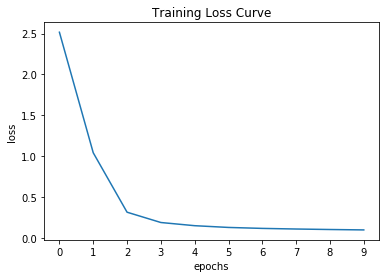

temperature: 0.2. generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK* with 0 mismatches from the wild type.
temperature: 0.8. generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDDHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK* with 1 mismatches from the wild type.
temperature: 1.0. generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVPTLVSTLYGVQCFSRYPDHMKQHDFSKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDSKEDGNILGHKLEYNYNSCNVYIMADKQKNGIKVNFKIRHNIVDGNVQLGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPAPWPTLVTTLSYGVQCFSRYPDH with 172 mismatches from the wild type.
temperature: 1.2. generated sequence: SKGEELFTGVVPILV

In [5]:
rnn = GenerativeRNN(args)
logger = open("./logs/{0}.txt".format(args["name"]), "w")
rnn.fit(dataloader=dataloader, logger=logger)
rnn.show_model()
rnn.plot_history("./logs/{0}_training_history".format(args["name"]))
rnn.plot_model("./logs/{0}_model_architecture".format(args["name"]))
temperature_lst = [0.2, 0.8, 1.0, 1.2, 1.8]
for temperature in temperature_lst: 
    generated_sequence = rnn.sample(predict_len = len(wild_type) - 1, prime_str = "S", temperature = temperature)
    mismatches = count_substring_mismatch(wild_type, generated_sequence)
    print("temperature: {0}. generated sequence: {1} with {2} mismatches from the wild type.".format(temperature, generated_sequence, mismatches), file=logger) 
logger.close()

In [6]:
def enumerate_all_sequences(model, string, base = "S", depth = 3): 
    if depth == 0: 
        return np.e ** model.predict_log_prob(string, base)
    total = 0
    for c in get_all_amino_acids(): 
        total += enumerate_all_sequences(model, string + c, base, depth - 1)
    return total

for depth in range(1, 4):
    for base in "QRST":
        np.testing.assert_almost_equal(1, enumerate_all_sequences(rnn, "", base, depth))


In [7]:
epoch = 8
load_rnn = GenerativeRNN(args)
load_rnn.load_model("./checkpoint_{0}.pt".format(epoch))
total_loss = []
for i, (input, target) in enumerate(dataloader):
    batch_size, seq_length = input.shape[0], input.shape[1]
    hidden = load_rnn.model.init_hidden(batch_size)
    loss = 0
    for c in range(seq_length):
        output, hidden = load_rnn.model(input[:, c], hidden)
        loss += load_rnn.criterion(output.view(batch_size, -1), target[:, c])
    total_loss.append(loss.item() / seq_length) 
print(total_loss)
print(torch.load("./models/rnn_test_sample/checkpoint_{0}.pt".format(epoch))["loss"])

/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


[tensor(1.00000e-02 *
       7.6142), tensor(1.00000e-02 *
       9.9237), tensor(0.1153), tensor(0.1120), tensor(0.1042), tensor(1.00000e-02 *
       7.5500), tensor(0.1046), tensor(1.00000e-02 *
       9.2714), tensor(1.00000e-02 *
       8.2159), tensor(0.1154)]
[tensor(1.00000e-02 *
       9.7746), tensor(0.1194), tensor(0.1002), tensor(1.00000e-02 *
       9.2724), tensor(0.1102), tensor(0.1109), tensor(0.1092), tensor(0.1286), tensor(0.1177), tensor(1.00000e-02 *
       7.7318)]
